In [136]:
#Time to Vector(T2V) Model

import keras
from keras.layers import LSTM, Dense
import tensorflow as tf

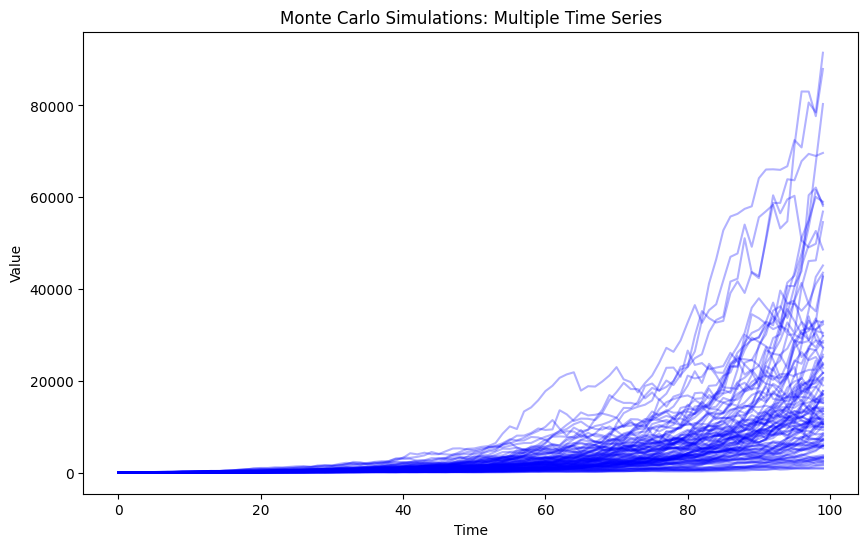

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
n_simulations = 100  # Number of simulations
n_time_points = 100  # Number of time points in each series
mu = 0.05  # Mean return (drift)
sigma = 0.1  # Standard deviation (volatility)
initial_value = 100  # Initial value of the time series

# Function to simulate a single time series
def simulate_time_series(mu, sigma, n_time_points, initial_value):
    dt = 1  # Time step
    time_series = [initial_value]
    for _ in range(1, n_time_points):
        # Generate a random shock (standard normal)
        shock = np.random.normal(mu * dt, sigma * np.sqrt(dt))
        time_series.append(time_series[-1] * np.exp(shock))  # Update value
    return time_series

# Generate multiple time series
simulated_data = np.array([simulate_time_series(mu, sigma, n_time_points, initial_value) for _ in range(n_simulations)])


# Plot the results
plt.figure(figsize=(10, 6))
for series in simulated_data:
    plt.plot(series, color='blue', alpha=0.3)  # Plot each series with transparency
plt.title('Monte Carlo Simulations: Multiple Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [138]:
from keras.layers import Layer, Input, LSTM, Dense
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf

# Time2Vec Layer
class T2V(Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer='uniform',
                                 trainable=True)
        self.P = self.add_weight(name='P',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='uniform',
                                 trainable=True)
        self.w = self.add_weight(name='w',
                                 shape=(input_shape[1], 1),
                                 initializer='uniform',
                                 trainable=True)
        self.p = self.add_weight(name='p',
                                 shape=(input_shape[1], 1),
                                 initializer='uniform',
                                 trainable=True)
        super(T2V, self).build(input_shape)

    def call(self, x):
        original = self.w * x + self.p
        sin_trans = tf.sin(tf.matmul(x, self.W) + self.P)  # Use tf.sin and tf.matmul instead of K.sin and K.dot
        return tf.concat([sin_trans, original], -1)  # Use tf.concat instead of K.concatenate


# Build the model with T2V embeddings
def T2V_NN(param, dim):
    inp = Input(shape=(dim, 1))
    t2v_output = T2V(output_dim=param['t2v_dim'], input_dim=dim)(inp)  # Pass `output_dim` as a keyword argument
    x = LSTM(param['unit'], activation=param['act'])(t2v_output)  # LSTM layer expects (None, time_steps, 2 * t2v_dim)
    x = Dense(1)(x)  # Final Dense layer for prediction

    model = Model(inp, x)
    
    # Create a model to output embeddings from T2V layer
    embedding_model = Model(inputs=inp, outputs=t2v_output)  # This gives you the raw embeddings

    model.compile(loss='mse', optimizer=Adam(learning_rate=param['lr']))  # Updated to use 'learning_rate'

    return model, embedding_model

In [139]:
# Prepare data
X = simulated_data[:, :-1]  # Use all but the last time point for features
y = simulated_data[:, 1:]   # Use all but the first time point for labels

# Reshape X to be compatible with LSTM input shape (samples, time_steps, features)
X = X.reshape((n_simulations, n_time_points-1, 1))  # Shape: (100, 99, 1)
y = y.reshape((n_simulations, n_time_points-1, 1))  # Shape: (100, 99, 1)

# Define hyperparameters
params = {
    't2v_dim': 12,  # Output dimension of Time2Vec
    'unit': 64,    # Number of units in LSTM layer
    'act': 'tanh',  # Activation function
    'lr': 0.001    # Learning rate
}

In [140]:
# Build models
prediction_model, embedding_model = T2V_NN(params, n_time_points-1)

# Train the prediction model
prediction_model.fit(X, y, epochs=10, batch_size=32)

/var/folders/cf/3rb10wvd7l5bcg3nnk3w22000000gn/T/ipykernel_84916/3669675609.py:10: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(T2V, self).__init__(**kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 70774872.0000
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 70370432.0000
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 77220840.0000
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 70091608.0000
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 67970592.0000
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 80556576.0000
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 74350552.0000
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 74756616.0000
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 69145824.0000
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 77862176.0000


In [141]:
# Now, get embeddings
embeddings = embedding_model.predict(X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [142]:
embeddings.shape

(100, 99, 13)

In [143]:
from sklearn.ensemble import IsolationForest

# Flatten the embeddings if necessary for the Isolation Forest
flattened_embeddings = embeddings.reshape(embeddings.shape[0], -1)

# Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.1)  # Adjust contamination based on your dataset
anomaly_labels = iso_forest.fit_predict(flattened_embeddings)

# Print anomaly labels (1 for normal, -1 for anomaly)
print(anomaly_labels)

[-1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1]


In [144]:
#Nonlinear dimensionality reduction and clustering with with K-means 

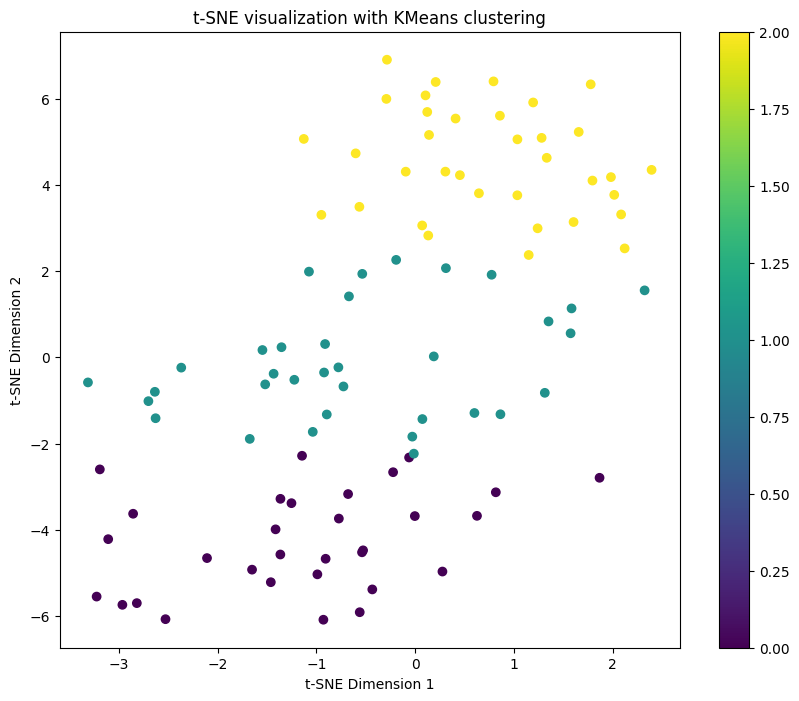

In [154]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming `embeddings` is your (100, 99, 13) array from the T2V model
embeddings_reshaped = embeddings.reshape(100, -1)  # Shape: (100, 1287)

# Step 1: Reduce dimensionality using t-SNE (to 2D for clustering and visualization)
tsne = TSNE(n_components=2, metric='cosine', random_state=42)  # Using Cosine similarity
embeddings_tsne = tsne.fit_transform(embeddings_reshaped)

# Step 2: Apply KMeans clustering (assume 3 clusters for this example)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings_tsne)

# Visualize the result
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', marker='o')
plt.colorbar()  # Color bar to indicate cluster labels
plt.title("t-SNE visualization with KMeans clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
